<a href="https://colab.research.google.com/github/pranavb200/Telco-Customer-Churn-Prediction/blob/main/telco_customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# ======================================
# 💡 TELCO CUSTOMER CHURN PREDICTION
# ======================================

# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# STEP 2: LOAD DATA
df = pd.read_csv("Telco-Customer-Churn.csv")

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# STEP 3: CLEANING AND PREPROCESSING
df.columns = df.columns.str.strip()
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID (not useful for model training)
df.drop('customerID', axis=1, inplace=True)

# Encode categorical columns with one LabelEncoder per column
label_encoders = {}
for col in df.select_dtypes('object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # store encoder for later use

In [ ]:
# STEP 4: FEATURE SCALING & SPLITTING
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# STEP 5: DEFINE AND TRAIN MULTIPLE MODELS
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    results.append([name, acc, auc, f1, prec, rec])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC-AUC', 'F1 Score', 'Precision', 'Recall'])
print(results_df)


                 Model  Accuracy   ROC-AUC  F1 Score  Precision    Recall
0  Logistic Regression  0.799148  0.840239  0.591631   0.642633  0.548128
1        Random Forest  0.787793  0.825353  0.553064   0.627119  0.494652
2     SVM (RBF Kernel)  0.793471  0.790907  0.551618   0.650909  0.478610
3    Gradient Boosting  0.803407  0.842387  0.580938   0.668990  0.513369


In [ ]:
# STEP 6: MODEL PERFORMANCE VISUALIZATION
fig = px.bar(
    results_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
    x='Model', y='Score', color='Metric',
    barmode='group',
    title='📊 Model Performance Comparison',
    text='Score'
)
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(xaxis_title="Model", yaxis_title="Score", title_font_size=22)
fig.show()


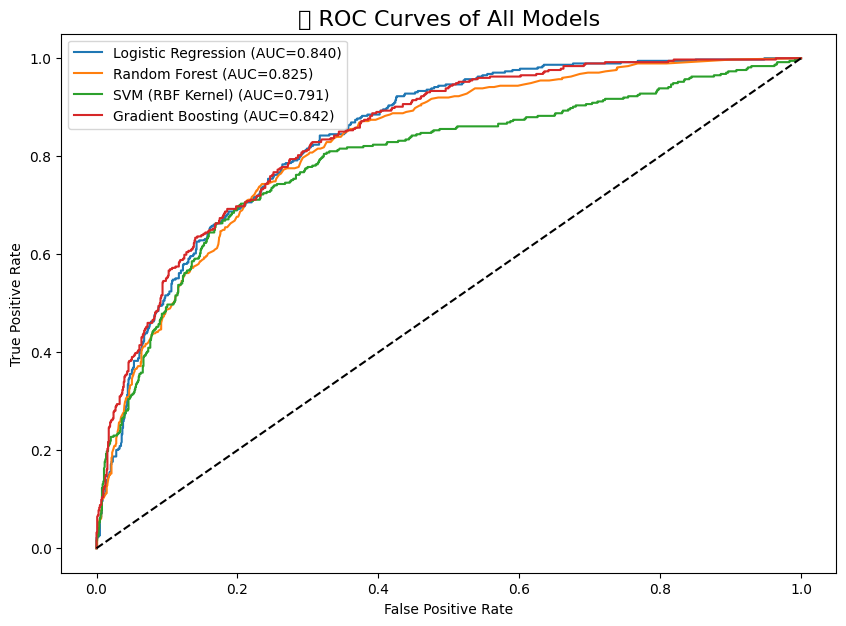

In [ ]:
# STEP 7: ROC CURVES COMPARISON

plt.figure(figsize=(10, 7))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("🔥 ROC Curves of All Models", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
# STEP 8: BEST MODEL SELECTION
best_model_name = results_df.sort_values(by="Accuracy", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]
print(f"✅ Best Performing Model: {best_model_name}\n")

✅ Best Performing Model: Gradient Boosting



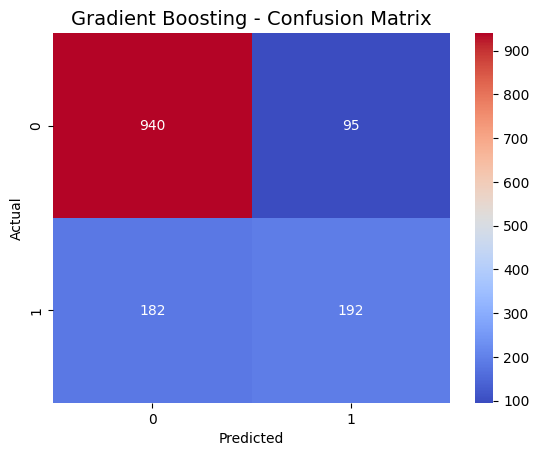

In [ ]:
# STEP 9: CONFUSION MATRIX AND CLASSIFICATION REPORT

cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title(f"{best_model_name} - Confusion Matrix", fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# STEP 10: FEATURE IMPORTANCE
if hasattr(best_model, "feature_importances_"):
    feat_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    fig = px.bar(
        feat_imp.head(15),
        x='Importance', y='Feature', orientation='h',
        title=f"🌟 Top 15 Important Features - {best_model_name}",
        color='Importance', color_continuous_scale='Blues'
    )
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

In [ ]:
# STEP 11:  PREDICTION & INTERPRETATION
print(f"🧩 Using the best model ({best_model_name}) to make churn predictions...\n")

# Predict on test data
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Combine actual and predicted into a single DataFrame
pred_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Churn_Probability': y_pred_prob
})

# Add prediction label
pred_df['Prediction_Label'] = pred_df['Predicted'].apply(lambda x: "Churn" if x == 1 else "No Churn")

# Merge with original feature values (optional, to analyze who churned)
full_pred = pd.concat([pd.DataFrame(X_test, columns=X.columns), pred_df.reset_index(drop=True)], axis=1)

# Show sample predictions
print("🎯 Sample Predictions (Actual vs Predicted):\n")
display(full_pred.head(10))

🧩 Using the best model (Gradient Boosting) to make churn predictions...

🎯 Sample Predictions (Actual vs Predicted):



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual,Predicted,Churn_Probability,Prediction_Label
0,0.990532,-0.439916,1.034530,1.529024,1.613701,0.327438,1.117034,0.172250,1.407321,1.242550,...,1.138411,1.570749,0.829798,-0.537747,1.638143,2.731119,0,0,0.016963,No Churn
1,-1.009559,2.273159,-0.966622,-0.654012,-0.992402,0.327438,1.117034,0.172250,-0.918838,-1.029919,...,1.138411,-0.828207,0.829798,-0.537747,1.176164,-0.606314,0,1,0.846298,Churn
2,-1.009559,-0.439916,1.034530,1.529024,0.351370,0.327438,1.117034,-1.183234,1.407321,1.242550,...,-1.121405,0.371271,0.829798,-0.537747,0.451620,0.410260,0,0,0.068073,No Churn
3,0.990532,-0.439916,1.034530,-0.654012,-0.585198,0.327438,-0.991588,0.172250,-0.918838,-1.029919,...,-1.121405,-0.828207,-1.205113,0.398558,0.446635,-0.358997,0,0,0.271821,No Churn
4,-1.009559,-0.439916,1.034530,-0.654012,1.613701,0.327438,1.117034,-1.183234,1.407321,1.242550,...,1.138411,1.570749,0.829798,-0.537747,0.594535,1.605853,0,0,0.017084,No Churn
5,-1.009559,-0.439916,-0.966622,-0.654012,-0.463037,0.327438,1.117034,0.172250,-0.918838,1.242550,...,1.138411,-0.828207,0.829798,-0.537747,1.166193,-0.127750,0,1,0.661359,Churn
6,-1.009559,-0.439916,-0.966622,-0.654012,-0.463037,0.327438,-0.991588,0.172250,-0.918838,1.242550,...,1.138411,-0.828207,0.829798,-1.474052,1.142928,-0.143709,0,1,0.533695,Churn
7,0.990532,-0.439916,-0.966622,1.529024,-0.544478,0.327438,1.117034,1.527734,0.244242,0.106315,...,0.008503,-0.828207,0.829798,-0.537747,-1.351430,-0.813522,0,0,0.111902,No Churn
8,-1.009559,-0.439916,1.034530,1.529024,1.165777,0.327438,-0.991588,1.527734,0.244242,0.106315,...,0.008503,1.570749,-1.205113,-0.537747,-1.496006,-0.428375,0,0,0.014096,No Churn
9,0.990532,2.273159,-0.966622,-0.654012,-0.625919,0.327438,-0.991588,-1.183234,-0.918838,-1.029919,...,-1.121405,-0.828207,0.829798,0.398558,-0.655137,-0.667216,1,0,0.380630,No Churn


In [ ]:
# STEP 12: REAL-WORLD CHURN PREDICTIONS WITH CUSTOMER IDs
print(f"🧩 Using the best model ({best_model_name}) to make churn predictions...\n")

# Reload dataset with CustomerID
df_with_id = pd.read_csv("Telco-Customer-Churn.csv")
df_with_id.columns = df_with_id.columns.str.strip()

# Clean TotalCharges
df_with_id['TotalCharges'] = df_with_id['TotalCharges'].replace(" ", np.nan)
df_with_id['TotalCharges'] = df_with_id['TotalCharges'].astype(float)
df_with_id['TotalCharges'].fillna(df_with_id['TotalCharges'].median(), inplace=True)

# Preserve CustomerID
customer_ids = df_with_id['customerID']

# Drop CustomerID for feature transformation
df_no_id = df_with_id.drop('customerID', axis=1)

# Apply saved encoders (from training)
for col in df_no_id.select_dtypes('object').columns:
    if col in label_encoders:
        le = label_encoders[col]
        df_no_id[col] = df_no_id[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    else:
        print(f"⚠️ Skipping column '{col}' — no encoder found.")

# Split X, y
X_all = df_no_id.drop('Churn', axis=1)
y_all = df_no_id['Churn']

# 🔥 Use same scaler (DO NOT FIT AGAIN)
X_all_scaled = scaler.transform(X_all)

# Predict churn
y_pred_all = best_model.predict(X_all_scaled)
y_prob_all = best_model.predict_proba(X_all_scaled)[:, 1]

# Combine results
final_predictions = pd.DataFrame({
    'CustomerID': customer_ids,
    'Actual_Churn': y_all,
    'Predicted_Churn': y_pred_all,
    'Churn_Probability': y_prob_all
})
final_predictions['Prediction_Label'] = final_predictions['Predicted_Churn'].map({1: 'Churn', 0: 'No Churn'})

# Display top 10 risky customers
top_risk = final_predictions.sort_values(by='Churn_Probability', ascending=False).head(10)
print("🚨 Top 10 Customers Most Likely to Churn:\n")
display(top_risk)




🧩 Using the best model (Gradient Boosting) to make churn predictions...

🚨 Top 10 Customers Most Likely to Churn:



,CustomerID,Actual_Churn,Predicted_Churn,Churn_Probability,Prediction_Label
2208,7216-EWTRS,1,1,0.960713,Churn
1704,0107-YHINA,1,1,0.957474,Churn
6623,9248-OJYKK,1,1,0.955632,Churn
6482,5419-JPRRN,1,1,0.952055,Churn
7032,6894-LFHLY,1,1,0.951910,Churn
4800,9300-AGZNL,1,1,0.948771,Churn
2191,3988-RQIXO,1,1,0.944714,Churn
1976,9497-QCMMS,1,1,0.943282,Churn
2577,4910-GMJOT,1,1,0.942884,Churn
6089,8775-LHDJH,1,1,0.941491,Churn


In [ ]:
# STEP 13: CHURN PROBABILITY DISTRIBUTION
fig = px.histogram(
    final_predictions,
    x="Churn_Probability",
    color="Prediction_Label",
    nbins=40,
    title="📈 Churn Probability Distribution Across All Customers",
    marginal="box",
    color_discrete_map={'Churn': 'crimson', 'No Churn': 'seagreen'}
)
fig.update_layout(xaxis_title="Predicted Churn Probability", yaxis_title="Number of Customers", title_font_size=20)
fig.show()


In [ ]:
# STEP 14: CUSTOMER-WISE CHURN SCATTER PLOT
fig = px.scatter(
    final_predictions,
    x='CustomerID',
    y='Churn_Probability',
    color='Prediction_Label',
    title='🎯 Customer-wise Churn Probability',
    hover_data=['CustomerID', 'Churn_Probability'],
    color_discrete_map={'Churn': 'red', 'No Churn': 'green'}
)
fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(xaxis_title="Customer ID", yaxis_title="Predicted Churn Probability")
fig.show()

In [ ]:
# STEP 15: MANUAL PREDICTION FOR NEW CUSTOMER (FINAL)
print("\n✨ Predicting churn for a new customer record:\n")

new_customer = pd.DataFrame([{
    'customerID': 'CUST9999',
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 4,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 75.5,
    'TotalCharges': 320.5
}])

# Encode new customer
new_customer_noid = new_customer.drop('customerID', axis=1)
for col in new_customer_noid.select_dtypes('object').columns:
    if col in label_encoders:
        le = label_encoders[col]
        new_customer_noid[col] = new_customer_noid[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Scale using same scaler
new_customer_scaled = scaler.transform(new_customer_noid)

# Predict churn
pred = best_model.predict(new_customer_scaled)[0]
prob = best_model.predict_proba(new_customer_scaled)[0][1]

if pred == 1:
    print(f"🚨 Customer {new_customer['customerID'][0]} is LIKELY to CHURN (Probability: {prob:.2f})")
else:
    print(f"✅ Customer {new_customer['customerID'][0]} is NOT likely to churn (Probability: {prob:.2f})")


✨ Predicting churn for a new customer record:

✅ Customer CUST9999 is NOT likely to churn (Probability: 0.48)
